In [1]:
import numpy as np
import pandas as pd
import math
import copy
import random
import plconnect.functions as plf
import scipy
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import johnsonsu, genlogistic,norm,pearson3
from scipy import interpolate
from matplotlib import pyplot as plt
%matplotlib inline
from random import seed
from IPython.display import clear_output
import pickle
from collections import OrderedDict
import os


In [2]:
#Loading data

uwi_list = []
dataset = None
#Define the independent variables and the dependent variable. The last variable is the target
curves_to_fetch =  ["RHOB","ILD", "GR", "PHIT_D","Facies2","VCLQ"]   #"RHOMAND"

#Define the set above with depth included, cleaning up any &/$ 

curves_to_fetch_prediction = copy.deepcopy(curves_to_fetch)
#print(curves_to_fetch_prediction)



column_names = ["DEPTH"]
for curve_name in curves_to_fetch:
    column_names.append(curve_name)

#print(column_names)


training_zones = ["Green"] #Add more zones that do not overlap to filter to higher quality training data 
    

grid = "Same As:{}".format(curves_to_fetch[-1])  #Can also be default. It's set to Same as Target curve 

 
SelectTrainingWellsFromAGroup = False  
TrainingWellsGroupName = "AllProjWells"  #If SelectTrainingWellsFromAGroup=True then this well group will be used


def get_uwis_in_well_group(group):
    from plconnect.filters import DataFilter, DataFilterClassNames, DataFilterCondition, DataFilterFunctions, DataFilterOperator, DataFilterClauses
    f = DataFilter()
    conditions = []
    f.add_resultset(Function = DataFilterFunctions.Select, What = DataFilterClassNames.Wells, From="Group:{}".format(group), Conditions = conditions)
    result = f.run(columns=["UWI"])
    if result.shape[0] > 0:
        return result.UWI.tolist()


    
uwi_list = []
if SelectTrainingWellsFromAGroup:
    uwi_list = get_uwis_in_well_group(TrainingWellsGroupName)
    if len(uwi_list) == 0:
        sys.stderr.write("Error: No wells  in the specified Well Group {}".format(TrainingWellsGroupName) )
    
else:
    uwi_list = plf.get_current_selected_wells()


frames = []

#########Fetch Training data#########################
#If you are using multiple zones ensure the zones don't overlap

print(uwi_list)


for uwi in uwi_list:
    for zone in training_zones:

        df = plf.get_curveexpressions_for_uwi(uwi, curves_to_fetch, training_zones[0], grid = grid)
        df.columns = column_names #Fix columns names (remove &)
        df.dropna(inplace = True)
       
        frames.append(df) #add it to the list of training sets

    
    
    
for curve_name in curves_to_fetch:
    column_names.append(curve_name)


dataset = pd.concat(frames)
print(dataset)
#dataset.drop(["DEPTH"], axis=1, inplace = True)
rhob = list(dataset['RHOB'])   #Here, len(rhob) =19003
phit_d = list(dataset['PHIT_D'])   #Here, len(rhob) =19003
depth = list(dataset['DEPTH'])   #Here, len(rhob) =19003


['608174035200']
      DEPTH    RHOB     ILD       GR    PHIT_D  Facies2     VCLQ
0    6102.0  2.2290   0.594   97.737  0.086231      0.0  0.98394
1    6102.5  2.2340   0.607   98.392  0.082226      0.0  0.98530
2    6103.0  2.2330   0.620   99.422  0.079851      0.0  1.00000
3    6103.5  2.2290   0.629   99.197  0.082836      0.0  1.00000
4    6104.0  2.2270   0.639   99.265  0.085001      0.0  0.99682
5    6104.5  2.2310   0.654  100.590  0.098229      0.0  0.91906
6    6105.0  2.2400   0.680  101.248  0.115463      0.0  0.80044
7    6105.5  2.2520   0.726   99.841  0.124972      0.0  0.70706
8    6106.0  2.2650   0.806   95.953  0.118202      0.0  0.69494
9    6106.5  2.2780   0.937   90.022  0.100776      0.0  0.73798
10   6107.0  2.2830   1.116   85.353  0.090042      0.0  0.77434
11   6107.5  2.2750   1.350   84.747  0.095238      0.0  0.77674
12   6108.0  2.2610   1.713   86.899  0.113573      0.0  0.73366
13   6108.5  2.2500   2.358   88.717  0.139851      0.0  0.63472
14   610

In [3]:
#Set Num_samples
Num_samples = len(dataset['DEPTH'])

#Setting no. of iterations

def createList(r1, r2):
    return ((np.arange(r1, r2+1, 1)))

#ITER = createList(50, 100)
ITER = [5,10,15,20,30,40,50,60,70,80,90,100]   
print(len(ITER))


12


Here is the Histogram VCLQ data:


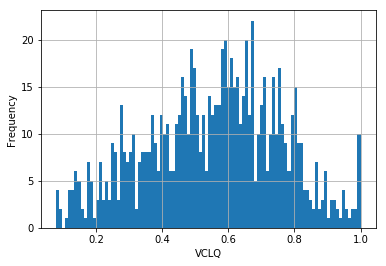


For this VCLQ data:
max = 1.0 
min = 0.07925 
mode = 1.0 
range = 0.92075 
mean = 0.5547041736028535 
variance 0.0412461384451199
-----------------------------


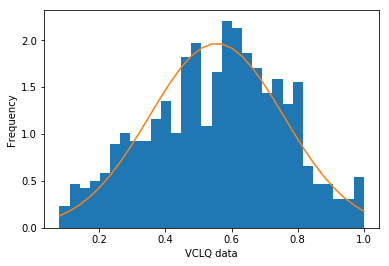

In [4]:
#VCLQ distribution
vclq = list(dataset['VCLQ'])
print("Here is the Histogram VCLQ data:")
hist = dataset['VCLQ'].hist(bins=100)
plt.xlabel("VCLQ")
plt.ylabel("Frequency")
plt.show()

# Max anad Min for the GR
vclq_max_value = dataset['VCLQ'].max() 
vclq_min_value = dataset['VCLQ'].min()


#Finding max, min, mode, range, and mean for the distribution 
df_vclq_modes = dataset['VCLQ'].mode()
df_vclq_mode = df_vclq_modes.max()
vclq_mode = df_vclq_mode 
vclq_range = vclq_max_value - vclq_min_value
vclq_mean = dataset['VCLQ'].mean()
vclq_variance = dataset['VCLQ'].var()
print('\nFor this VCLQ data:\nmax =',vclq_max_value,'\nmin =',vclq_min_value,'\nmode =',vclq_mode,'\nrange =',vclq_range,'\nmean =',vclq_mean,'\nvariance',vclq_variance)   
print('-----------------------------')
lenvclq = len(vclq)


# Test for Distribution curve fitting for VCLQ data:

_, bins, _ = plt.hist(vclq, 30, density=1)
vclqg1, vclqg2 = scipy.stats.norm.fit(vclq)
best_fit_line = scipy.stats.norm.pdf(bins, vclqg1,vclqg2)
plt.plot(bins, best_fit_line) 
plt.xlabel("VCLQ data")
plt.ylabel("Frequency")
plt.show()


In [5]:
#Data By Facies

facies = list(dataset['Facies2'])

#For VCLQ data:

vclq = list(dataset['VCLQ'])

def VCLQ_Data():
    i,X,L,Y = 0,[],[],[]
    for i in range(Num_samples):
        if facies[i] == 0:
            X.append(vclq[i])  
        if facies[i] == 1:
            L.append(vclq[i])     
        if facies[i] == 2:
            Y.append(vclq[i])
    return(X,L,Y)

vclqshale , vclqsandbrine, vclqsandHC = VCLQ_Data()
lenrsh, lenrsdbr, lenrsdhc  = len(vclqshale), len(vclqsandbrine), len(vclqsandHC)

min_vclqshale,     max_vclqshale     = min(vclqshale),     max(vclqshale)
min_vclqsandbrine, max_vclqsandbrine = min(vclqsandbrine), max(vclqsandbrine)
min_vclqsandHC,    max_vclqsandHC    = min(vclqsandHC),    max(vclqsandHC)


# Useful functions:

def varystuff(stuff ,length, Min,Max,S):           
    L = []
    random.seed(S)
    for i in range(length):
        p,pp = 0,0
        while pp<1:
            p = random.uniform(Min, Max)
            if p>stuff[i]:
                L.append(p)
                pp+=1
    return(L)

def normvarystuff(stuff ,length, mean,stddev):           
    L = []
    random.seed(10)
    for i in range(length):
        p,pp = 0,0
        while pp<1:
            p = np.random.normal(mean,stddev)
            if p>stuff[i]:
                L.append(p)
                pp+=1
    return(L)

def Remv_nan(A):
    L = []
    for i in range(len(ITER)):
        L.append([x for x in A[i] if pd.isnull(x) == False])
    return(L)


In [1]:
# Facieswise Distribution Fits for Vcl data:

_, bins, _ = plt.hist(vclqshale, 30, density=1)
f1vclqg1, f1vclqg2,f1vclqg3 = scipy.stats.pearson3.fit(vclqshale)
best_fit_line = scipy.stats.pearson3.pdf(bins, f1vclqg1,f1vclqg2,f1vclqg3)
plt.plot(bins, best_fit_line) 
plt.xlabel("Shale VCLQ data")
plt.ylabel("Frequency")
plt.show()


_, bins, _ = plt.hist(vclqsandbrine, 30, density=1)
f2vclqg1, f2vclqg2,f2vclqg3 = scipy.stats.pearson3.fit(vclqsandbrine)
best_fit_line = scipy.stats.pearson3.pdf(bins, f2vclqg1,f2vclqg2,f2vclqg3)
plt.plot(bins, best_fit_line) 
plt.xlabel("Brine Sands VCLQ data")
plt.ylabel("Frequency")
plt.show()


_, bins, _ = plt.hist(vclqsandHC, 30, density=1)
f3vclqg1, f3vclqg2,f3vclqg3 = scipy.stats.pearson3.fit(vclqsandHC)
best_fit_line = scipy.stats.pearson3.pdf(bins, f3vclqg1,f3vclqg2,f3vclqg3)
plt.plot(bins, best_fit_line) 
plt.xlabel("Hydrocarbon sands VCLQ data")
plt.ylabel("Frequency")
plt.show()

params = stats.pearson3.fit(vclqsandHC)                 #print(params)
def your_density(x):
    return -stats.pearson3.pdf(x,*params)
ASD = minimize(your_density,0.5).x
print('Peak VCLQ value of HC sands',ASD)

NameError: name 'plt' is not defined

In [7]:
# Generating a Pearson Distribution random no. for VCL:

facies = list(dataset['Facies2'])

def get_Pearson_rand_number(g1,g2,g3,M1,M2,i,rb):
    j=0
    while ( j<1 ):
        Rp = pearson3.rvs(g1,g2,g3)
        if (Rp >= M1 and Rp <= M2):
            chk = ( 2.6 * (Rp - (Rp*0.1)) ) + ( 2.65 * (1-Rp) )       # RHOMA calculation
            if ( rb[i] < chk ):                    # RHOMA must always be greater than RHOB value               
                j+=1
                
    return(Rp)

#Generating 'NumS = num_samples of Pearson random no.s for VCL:
def get_N_Pearson_rand_numbers(NumS, g1,g2,g3, M1,M2,rb):
    L =[]
    for i in range(NumS):
        L.append(get_Pearson_rand_number(g1,g2,g3,M1,M2,i,rb))
    return(L)

def iter_vcl_Dist(itval,Ls,g1,g2,g3,M1,M2,rb):
    Li = []
    for i in range(itval):
        Li.extend(get_N_Pearson_rand_numbers(Ls,g1,g2,g3,M1,M2,rb))
    return(Li)

def fin_vcl(ITER, Ls ,g1,g2,g3,M1,M2,rb):
    Lit = []
    for i in range(len(ITER)):
        Lit.append(iter_vcl_Dist(ITER[i], Ls , g1,g2,g3, M1,M2, rb))
    return(Lit)


# Remember! f1 = shale facies, f2 = brine sands, f3 = HC sands

f1Vc = fin_vcl(ITER, lenrsh,   f1vclqg1,f1vclqg2,f1vclqg3, min_vclqshale,     max_vclqshale ,     rhob)
f2Vc = fin_vcl(ITER, lenrsdbr, f2vclqg1,f2vclqg2,f2vclqg3, min_vclqsandbrine, max_vclqsandbrine,  rhob)
f3Vc = fin_vcl(ITER, lenrsdhc, f3vclqg1,f3vclqg2,f3vclqg3, min_vclqsandHC,    max_vclqsandHC ,    rhob)
min(f1Vc[0])

0.58034899885761748

In [8]:
# P10, P50, P90 of the distribution of Vcl:


def split_data(G,it):
    L = copy.deepcopy(G)
    X=[]
    splits = np.array_split(L, it)
    for i in range(it):
        X.append(list(splits[i]))
    return(X) 


def itp10p50p90(G):
    L = copy.deepcopy(G)
    P10,P50,P90,p10,p50,p90 = [],[],[],[],[],[]    
    p10 = np.percentile(L, 90)
    p50 = np.percentile(L, 50)
    p90 = np.percentile(L, 10)
    i=0
    while (i<len(L)):     
        if L[i] <= p10:      
            P90.append(L[i])
        else: 
            P90.append(np.NaN)
            
        if L[i] <= p50:      
            P50.append(L[i])
        else: 
            P50.append(np.NaN)
            
        if L[i] <= p90:      
            P10.append(L[i])
        else:
            P10.append(np.NaN)
        i+=1    
        
    return(P10,P50,P90)


def p10_p50_p90values(G,i):
    L = split_data(G,i)
    A10,A50,A90 = [],[],[] 
    for i in range(len(L)):
        a, b, c = itp10p50p90(L[i])
        A10.extend(a)
        A50.extend(b)
        A90.extend(c)
    return(A10,A50,A90)

def Iter_P105090(G):
    f10,f50,f90 = [],[],[] 
    for i in range(len(ITER)):
        a ,b, c = p10_p50_p90values(G[i],ITER[i])
        f10.append(a)
        f50.append(b)
        f90.append(c)
    return(f10,f50,f90) 

# Based on Confidence interval of the most likely value:


def Vclitp10p50p90ConfInt(G,ig):
    L = copy.deepcopy(G)
    P10,P50,P90,p10,p50,p90 = [],[],[],[],[],[]
    
    params = stats.pearson3.fit(L)                 #print(params)
    def your_density(x):
        return -stats.pearson3.pdf(x,*params)
    ASD = minimize(your_density,ig).x                #print(ASD)

    c1,c2 =0,0
    for i in range(len(L)):
        if L[i]<=ASD:
            c1+=1
        elif L[i]>=ASD:
            c2+=1
                                                      #print(c1,c2)
    prop1,prop2 = c1/(c1+c2), c2/(c1+c2)
    c1+c2==len(L)

    p5  = np.percentile(L, (prop1*10))
    p95 = np.percentile(L, (100-(prop2*10)))
    p25 = np.percentile(L, (prop1*50))
    p75 = np.percentile(L, (100-(prop2*50)))
    p45 = np.percentile(L, prop1*90)
    p55 = np.percentile(L, (100-(prop2*90)))
    
    i=0
    while (i<len(L)):     
        if L[i]>= p45 and L[i] <= p55:      
            P10.append(L[i])
        else: 
            P10.append(np.NaN)
            
        if L[i]>= p25 and L[i] <= p75:
            P50.append(L[i])
        else: 
            P50.append(np.NaN)
        if L[i]>= p5 and L[i] <= p95:
            P90.append(L[i])
        else:
            P90.append(np.NaN)
        i+=1    
    return(P10,P50,P90)
    

def Vclp10p50p90listConfInt(G,i,ig):
    L = split_data(G,i)
    A10,A50,A90 = [],[],[]
    for i in range(len(L)):
        a ,b, c = Vclitp10p50p90ConfInt(L[i],ig)
        A10.extend(a)
        A50.extend(b)
        A90.extend(c)
    return(A10,A50,A90)


def VclIter_P105090ConfInt(G,ig):
    f10,f50,f90 = [],[],[]
    for i in range(len(ITER)):
        a ,b, c = Vclp10p50p90listConfInt(G[i],ITER[i],ig)
        f10.append(a)
        f50.append(b)
        f90.append(c)
    return(f10,f50,f90)  



f1Vcp10, f1Vcp50, f1Vcp90 = Iter_P105090(f1Vc)  #print(GLDp50), , 
f2Vcp10, f2Vcp50, f2Vcp90 = Iter_P105090(f2Vc)
f3Vcp10, f3Vcp50, f3Vcp90 = Iter_P105090(f3Vc)


f1Vcp10C, f1Vcp50C, f1Vcp90C = VclIter_P105090ConfInt(f1Vc,0.6)  #print(GLDp50), , 
f2Vcp10C, f2Vcp50C, f2Vcp90C = VclIter_P105090ConfInt(f2Vc,0.5)
f3Vcp10C, f3Vcp50C, f3Vcp90C = VclIter_P105090ConfInt(f3Vc,0.5)

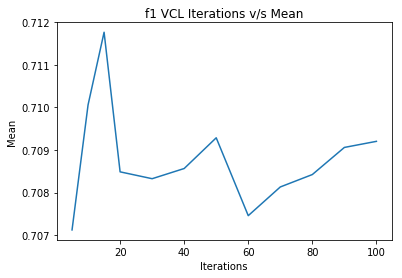

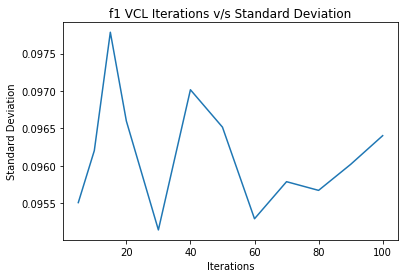

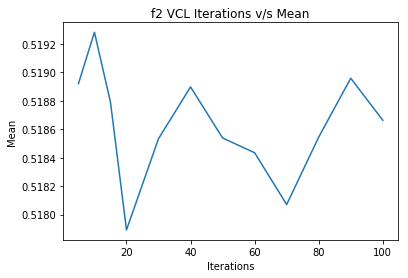

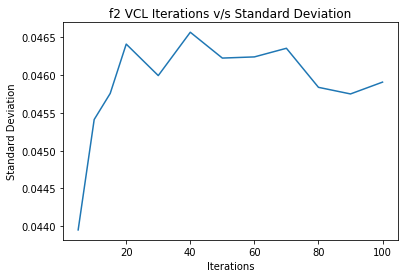

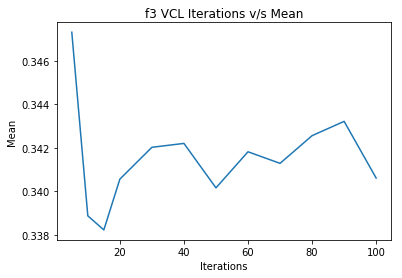

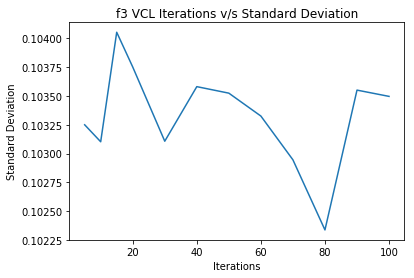

In [9]:
#Means and STDevs of VCL Data calculation

def Mean_stdev(A):
    Me,St = [],[]
    for i in range(len(A)):
        meen = np.mean(A[i])
        stdevin = np.std(A[i])
        Me.append(meen)
        St.append(stdevin)
    return(Me,St)

f1VshMean, f1VshSTDV = Mean_stdev(f1Vc)

#plotting the Mean and Std dev


plt.plot(ITER, f1VshMean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('f1 VCL Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, f1VshSTDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('f1 VCL Iterations v/s Standard Deviation')
plt.show()


f2VshMean, f2VshSTDV = Mean_stdev(f2Vc)

#plotting the Mean and Std dev


plt.plot(ITER, f2VshMean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('f2 VCL Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, f2VshSTDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('f2 VCL Iterations v/s Standard Deviation')
plt.show()


f3VshMean, f3VshSTDV = Mean_stdev(f3Vc)

#plotting the Mean and Std dev


plt.plot(ITER, f3VshMean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('f3 VCL Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, f3VshSTDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('f3 VCL Iterations v/s Standard Deviation')
plt.show()


Here is the Histogram RHOB data:


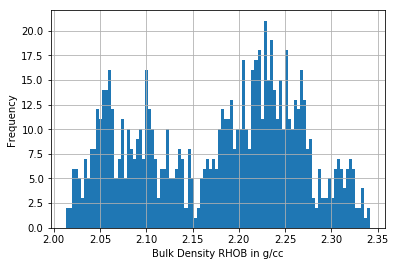


For this RHOB data:
max = 2.3419 
min = 2.013 
mode = 2.193 
range = 0.3289 
mean = 2.1765495838287716 
variance 0.0072853697170884935
-----------------------------


In [10]:
# Generating  Histogram for Bulk Density Data

#RHOMA=2.65  #print(x)
RHOF= 1   #rho fluid
print("Here is the Histogram RHOB data:")
hist = dataset['RHOB'].hist(bins=100)
plt.xlabel("Bulk Density RHOB in g/cc")
plt.ylabel("Frequency")
plt.show()
 
# Max anad Min for the RHOB
RHOB_max_value = dataset['RHOB'].max() 
RHOB_min_value = dataset['RHOB'].min()


#Finding max, min, mode, range, and mean for the distribution 
df_RHOB_modes = dataset['RHOB'].mode()
df_RHOB_mode = df_RHOB_modes.max()
RHOB_mode = df_RHOB_mode 
RHOB_range = RHOB_max_value - RHOB_min_value
RHOB_mean = dataset['RHOB'].mean()
RHOB_variance = dataset['RHOB'].var()
print('\nFor this RHOB data:\nmax =',RHOB_max_value,'\nmin =',RHOB_min_value,'\nmode =',RHOB_mode,'\nrange =',RHOB_range,'\nmean =',RHOB_mean,'\nvariance',RHOB_variance)   
print('-----------------------------')


In [11]:
# Rhob Data By Facies
facies = list(dataset['Facies2'])
def rhobData():
    i,X,L,Y = 0,[],[],[]
    for i in range(Num_samples):
        if facies[i] == 0:
            X.append(rhob[i])  
        if facies[i] == 1:
            L.append(rhob[i])     
        if facies[i] == 2:
            Y.append(rhob[i])
    return(X,L,Y)

rhobshale , rhobsandbrine, rhobsandHC = rhobData()
lenrsh, lenrsdbr, lenrsdhc  = len(rhobshale), len(rhobsandbrine), len(rhobsandHC)


In [12]:
len(f1Vc[0])

2060

In [13]:
#RHOMA Calculation

RHOBclay, RHOBqtz = 2.6, 2.65

def Iter_RHOMA(D):
    Lit =[]
    for i in range(len(D)):
        Lit.append(( (RHOBclay) * (D[i] - (D[i]*0.1)) ) + ( RHOBqtz * (1-D[i])))  #Rhomatrix= ((RHOBCLAY*VCLAY+RHOBQUARTZ*(1-VCLAY))
    return(Lit)
  #np.random.normal(2.5, 0.07,200)  #np.random.uniform(2.3,2.7,200)

lenf1RHOMA , lenf2RHOMA , lenf3RHOMA, tot_samples,f1RHOMA,f2RHOMA,f3RHOMA = [],[],[],[],[],[],[]
for i in range(len(ITER)):
        f1RHOMA.append(Iter_RHOMA(f1Vc[i])) #print(GLDRHOMA )
        f2RHOMA.append(Iter_RHOMA(f2Vc[i])) 
        f3RHOMA.append(Iter_RHOMA(f3Vc[i]))

for i in range(len(ITER)):
    lenf1RHOMA.append(len(f1RHOMA[i]))
    lenf2RHOMA.append(len(f2RHOMA[i]))
    lenf3RHOMA.append(len(f3RHOMA[i]))
    tot_samples.append(len(f1RHOMA[i])+len(f2RHOMA[i])+len(f3RHOMA[i]))

In [14]:
# Lets define the function of Density Porosity over which we are running Monte Carlo Simulation

def Eqn_Density_Porosity(rhoma,x):
    return ((rhoma-x)/(rhoma-RHOF))

#Porosity Distributions
def MC_density_porosity_nSamples(num_samples,RHOMA,rb):
    L =[]
    r = len(rb)
    for i in range(num_samples):
        L.append(Eqn_Density_Porosity(RHOMA[i],rb[i%r]))   #rhob[i]
    return(L)

f1Dp,f2Dp,f3Dp = [],[],[]

#Computing Density Porosity for facies

for i in range(len(ITER)):
    f1Dp.append(MC_density_porosity_nSamples(lenf1RHOMA[i],f1RHOMA[i],rhobshale))
    f2Dp.append(MC_density_porosity_nSamples(lenf2RHOMA[i],f2RHOMA[i],rhobsandbrine))
    f3Dp.append(MC_density_porosity_nSamples(lenf3RHOMA[i],f3RHOMA[i],rhobsandHC))



In [15]:
lenf1RHOMA[0]

2060

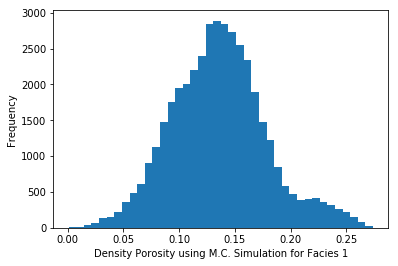

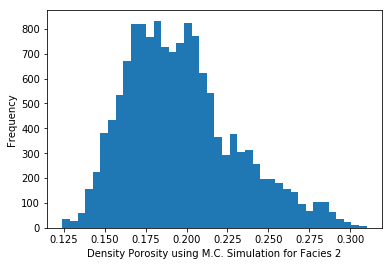

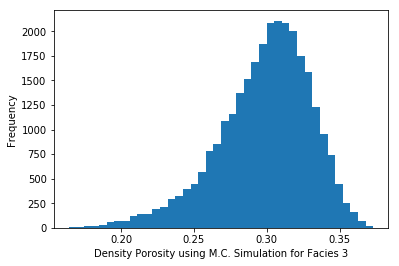

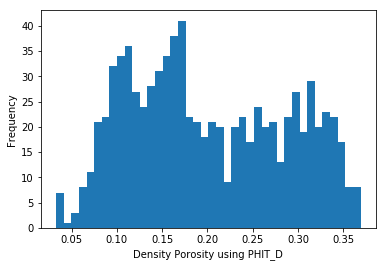

In [16]:
# Copying in data into a new list

f1DP =  copy.deepcopy(f1Dp)
f2DP =  copy.deepcopy(f2Dp)
f3DP =  copy.deepcopy(f3Dp)

#Display Porsity Distribution Plots

f1DPH = plt.hist(f1DP[-1], 40)
plt.xlabel("Density Porosity using M.C. Simulation for Facies 1")
plt.ylabel("Frequency")
plt.show()

f2DPH = plt.hist(f2DP[-1], 40)
plt.xlabel("Density Porosity using M.C. Simulation for Facies 2")
plt.ylabel("Frequency")
plt.show()

f3DPH = plt.hist(f3DP[-1], 40)
plt.xlabel("Density Porosity using M.C. Simulation for Facies 3")
plt.ylabel("Frequency")
plt.show()

PHIT_hist = plt.hist(phit_d,40)
plt.xlabel("Density Porosity using PHIT_D")
plt.ylabel("Frequency")
plt.show()



In [17]:
# P10, P50, P90 of the Porosity distribution Based on Confidence interval of the most likely value:

def Poritp10p50p90ConfInt(G):
    L = copy.deepcopy(G)
    P10,P50,P90,p10,p50,p90 = [],[],[],[],[],[]
    
    params = stats.genlogistic.fit(L)                 #print(params)
    def your_density(x):
        return -stats.genlogistic.pdf(x,*params)
    ASD = minimize(your_density,0.5).x                #print(ASD)

    c1,c2 =0,0
    for i in range(len(L)):
        if L[i]<=ASD:
            c1+=1
        elif L[i]>=ASD:
            c2+=1
                                                      #print(c1,c2)
    prop1,prop2 = c1/(c1+c2), c2/(c1+c2)
    c1+c2==len(L)

    p5  = np.percentile(L, (prop1*10))
    p95 = np.percentile(L, (100-(prop2*10)))
    p25 = np.percentile(L, (prop1*50))
    p75 = np.percentile(L, (100-(prop2*50)))
    p45 = np.percentile(L, prop1*90)
    p55 = np.percentile(L, (100-(prop2*90)))
    
    i=0
    while (i<len(L)):     
        if L[i]>= p45 and L[i] <= p55:      
            P10.append(L[i])
        else: 
            P10.append(np.NaN)
            
        if L[i]>= p25 and L[i] <= p75:
            P50.append(L[i])
        else: 
            P50.append(np.NaN)
        if L[i]>= p5 and L[i] <= p95:
            P90.append(L[i])
        else:
            P90.append(np.NaN)
        i+=1    
    return(P10,P50,P90)
    

def Porp10p50p90listConfInt(G,i):
    L = split_data(G,i)
    A10,A50,A90 = [],[],[]
    for i in range(len(L)):
        a ,b, c = Poritp10p50p90ConfInt(L[i])
        A10.extend(a)
        A50.extend(b)
        A90.extend(c)
    return(A10,A50,A90)


def PorIter_P105090ConfInt(G):
    f10,f50,f90 = [],[],[]
    for i in range(len(ITER)):
        a ,b, c = Porp10p50p90listConfInt(G[i],ITER[i])
        f10.append(a)
        f50.append(b)
        f90.append(c)
    return(f10,f50,f90)    
    

f1Dp10C, f1Dp50C, f1Dp90C = PorIter_P105090ConfInt(f1DP)  #print(GLDp50), , 
f2Dp10C, f2Dp50C, f2Dp90C = PorIter_P105090ConfInt(f2DP)
f3Dp10C, f3Dp50C, f3Dp90C = PorIter_P105090ConfInt(f3DP)



f1Dp10, f1Dp50, f1Dp90 = Iter_P105090(f1DP)  #print(GLDp50), , 
f2Dp10, f2Dp50, f2Dp90 = Iter_P105090(f2DP)
f3Dp10, f3Dp50, f3Dp90 = Iter_P105090(f3DP)


In [18]:
len(f2Dp10[0])

700

In [19]:
def porbunch(F1,F2,F3,it):
    i,f1,f2,f3, L = 0,0,0,0,[]

    while i<(tot_samples[it]):
        if i<tot_samples[it] and facies[i%Num_samples] == 0:
            L.append(F1[f1])
            f1+=1
        elif i<tot_samples[it] and facies[i%Num_samples] == 1:
            L.append(F2[f2])
            f2+=1       
        elif i<tot_samples[it] and facies[i%Num_samples] == 2:
            L.append(F3[f3])
            f3+=1   
        i+=1
    return(L)
FDP,VC = [],[]
for i in range(len(ITER)):
    FDP.append(porbunch(f1DP[i],f2DP[i],f3DP[i],i))    #print(FDP) len(FDP)
    VC.append( porbunch(f1Vc[i],f2Vc[i],f3Vc[i],i))    


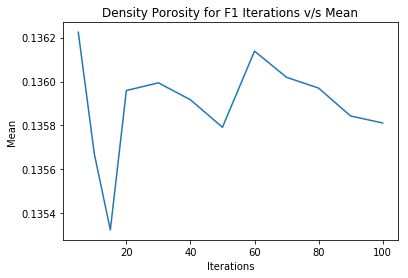

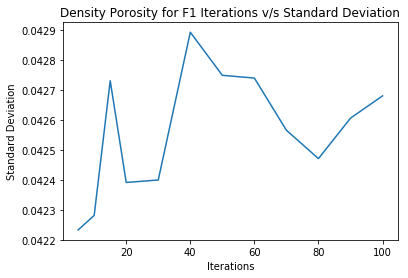

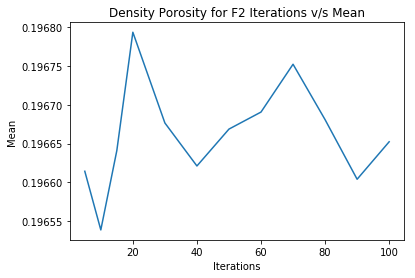

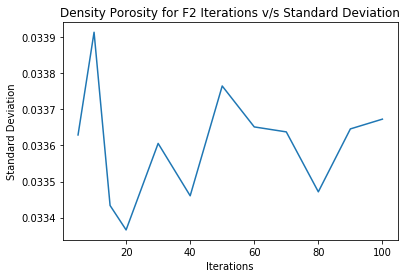

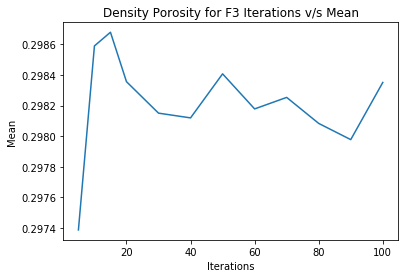

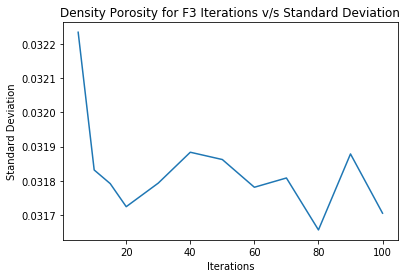

In [20]:
#Means and STDevs of Porosity Data calculation:

def Mean_stdev(A):
    Me,St = [],[]
    for i in range(len(A)):
        meen = np.mean(A[i])
        stdevin = np.std(A[i])
        Me.append(meen)
        St.append(stdevin)
    return(Me,St)

F1mean,F1STDV = Mean_stdev(f1DP)     #print(F1STDV)
F2mean,F2STDV = Mean_stdev(f2DP)
F3mean,F3STDV = Mean_stdev(f3DP)


# plotting the Mean and Std dev


plt.plot(ITER, F1mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('Density Porosity for F1 Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, F1STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('Density Porosity for F1 Iterations v/s Standard Deviation')
plt.show()

plt.plot(ITER, F2mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('Density Porosity for F2 Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, F2STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('Density Porosity for F2 Iterations v/s Standard Deviation')
plt.show()

plt.plot(ITER, F3mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('Density Porosity for F3 Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, F3STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('Density Porosity for F3 Iterations v/s Standard Deviation')
plt.show()

In [21]:
#Preping data to send to PL

def packrhob(Fp,j,S):
    L,k = [],0
    for i in range(tot_samples[S]):
        if facies[i%(len(depth))] == j:
            L.append(Fp[k])  
            k+=1
        else:
            L.append(np.nan)
    return(L)


def iter_packrhob(AA,jj):
    FC = []
    for I in range(len(ITER)):
        FC.append(packrhob(AA[I],jj,I))
    return(FC)


def faciespordata(Fpor,j):  
    FD = []
    for p in range(len(Fpor)):
        FD.append(iter_packrhob(Fpor[p],j))    
    return(FD[0],FD[1],FD[2],FD[3])


f1VCL  = [f1Vc,f1Vcp10, f1Vcp50, f1Vcp90]
f2VCL  = [f2Vc,f2Vcp10, f2Vcp50, f2Vcp90]
f3VCL  = [f3Vc,f3Vcp10, f3Vcp50, f3Vcp90]

f1VCLC = [f1Vc,f1Vcp10C, f1Vcp50C, f1Vcp90C]
f2VCLC = [f2Vc,f2Vcp10C, f2Vcp50C, f2Vcp90C]
f3VCLC = [f3Vc,f3Vcp10C, f3Vcp50C, f3Vcp90C]

F1Vc, F1Vcp10, F1Vcp50, F1Vcp90    = faciespordata(f1VCL,0) 
F2Vc, F2Vcp10, F2Vcp50, F2Vcp90    = faciespordata(f2VCL,1) 
F3Vc, F3Vcp10, F3Vcp50, F3Vcp90    = faciespordata(f3VCL,2) 

F1Vc, F1Vcp10C, F1Vcp50C, F1Vcp90C = faciespordata(f1VCLC,0) 
F2Vc, F2Vcp10C, F2Vcp50C, F2Vcp90C = faciespordata(f2VCLC,1) 
F3Vc, F3Vcp10C, F3Vcp50C, F3Vcp90C = faciespordata(f3VCLC,2) 

f1por = [f1DP,f1Dp10, f1Dp50, f1Dp90]
f2por = [f2DP,f2Dp10, f2Dp50, f2Dp90]
f3por = [f3DP,f3Dp10, f3Dp50, f3Dp90]

f1porC = [f1DP,f1Dp10C, f1Dp50C, f1Dp90C]
f2porC = [f2DP,f2Dp10C, f2Dp50C, f2Dp90C]
f3porC = [f3DP,f3Dp10C, f3Dp50C, f3Dp90C]


F1DP, F1Dp10, F1Dp50, F1Dp90 = faciespordata(f1por,0)
F2DP, F2Dp10, F2Dp50, F2Dp90 = faciespordata(f2por,1)
F3DP, F3Dp10, F3Dp50, F3Dp90 = faciespordata(f3por,2)

F1DP, F1Dp10C, F1Dp50C, F1Dp90C = faciespordata(f1porC,0) 
F2DP, F2Dp10C, F2Dp50C, F2Dp90C = faciespordata(f2porC,1) 
F3DP, F3Dp10C, F3Dp50C, F3Dp90C = faciespordata(f3porC,2) 


Here is the Histogram ILD data:


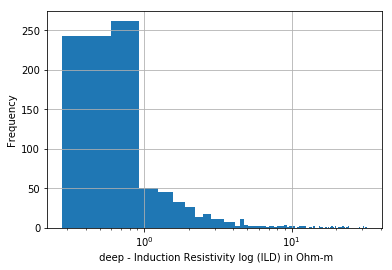


For this ILD data:
max = 32.251 
min = 0.279 
mode = 0.65 
range = 31.972 
mean = 2.5508406658739613 
variance 24.433031181725223
-----------------------------


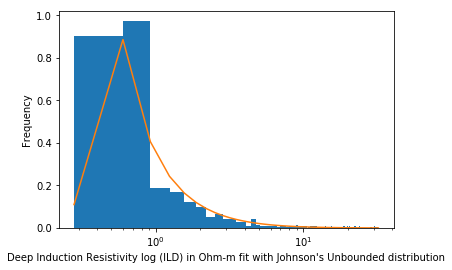

In [22]:
#ILD distribution
ild = list(dataset['ILD'])
print("Here is the Histogram ILD data:")
hist = dataset['ILD'].hist(bins=100)
plt.xlabel(" deep - Induction Resistivity log (ILD) in Ohm-m")
plt.ylabel("Frequency")
plt.xscale("log")
plt.show()

# Max anad Min for the GR
ILD_max_value = dataset['ILD'].max() 
ILD_min_value = dataset['ILD'].min()


#Finding max, min, mode, range, and mean for the distribution 
df_ILD_modes = dataset['ILD'].mode()
df_ILD_mode = df_ILD_modes.max()
ILD_mode = df_ILD_mode 
ILD_range = ILD_max_value - ILD_min_value
ILD_mean = dataset['ILD'].mean()
ILD_variance = dataset['ILD'].var()
print('\nFor this ILD data:\nmax =',ILD_max_value,'\nmin =',ILD_min_value,'\nmode =',ILD_mode,'\nrange =',ILD_range,'\nmean =',ILD_mean,'\nvariance',ILD_variance)   
print('-----------------------------')

# Test for Distribution curve fitting:


#Fit for Johnson's Unbounded distribution
_, bins, _ = plt.hist(dataset['ILD'], 100, density=1)
ILDj1, ILDj2, ILDj3, ILDj4 = scipy.stats.johnsonsu.fit(dataset['ILD'])
best_fit_line = scipy.stats.johnsonsu.pdf(bins, ILDj1, ILDj2, ILDj3,ILDj4)
plt.plot(bins, best_fit_line)
plt.xlabel("Deep Induction Resistivity log (ILD) in Ohm-m fit with Johnson's Unbounded distribution")
plt.ylabel("Frequency")
plt.xscale("log")
plt.show()  


In [23]:
#For ILD data:

def ILD_Data():
    i,X,L,Y = 0,[],[],[]
    for i in range(Num_samples):
        if facies[i] == 0:
            X.append(ild[i])  
        if facies[i] == 1:
            L.append(ild[i])     
        if facies[i] == 2:
            Y.append(ild[i])
    return(X,L,Y)

ildshale , ildsandbrine, ildsandHC = ILD_Data()
lenrsh, lenrsdbr, lenrsdhc  = len(ildshale), len(ildsandbrine), len(ildsandHC)

min_ildshale,     max_ildshale     = min(ildshale),     max(ildshale)
min_ildsandbrine, max_ildsandbrine = min(ildsandbrine), max(ildsandbrine)
min_ildsandHC,    max_ildsandHC    = min(ildsandHC),    max(ildsandHC)



def ILDcalc(A,i):
    L = [] 
    for j in range(i):
        L.extend(A)   
    return(L) 

def Iter_ILDcalc(AA):
    Liter = []
    for i in range(len(ITER)):
        Liter.append(ILDcalc(AA,ITER[i])  )  
    return(Liter)

f1ild = Iter_ILDcalc(ildshale)
f2ild = Iter_ILDcalc(ildsandbrine)
f3ild = Iter_ILDcalc(ildsandHC)
Fild  = Iter_ILDcalc(ild)

In [24]:
len(f1DP[0])

2060

In [25]:
#For saturation
a, m , n= 1, 1.8, 2  # From Pickett plot

#Formation factor:

def Formationf(phi):
    if phi== np.NaN:
        return(np.NaN)
    else: 
        F = a/(phi**(m))
        return (F)
    
    
def Iter_FF(A,S):
    AF= []
    for i in range(S):
        AF.append(Formationf(A[i]))
    return(AF)
        
def n_Iter_FF(aa,bb):
    AF = []
    for i in range(len(ITER)):
        AF.append((Iter_FF(aa[i],bb[i])))
    return(AF)

f1F  = n_Iter_FF(f1DP,lenf1RHOMA)
f2F  = n_Iter_FF(f2DP,lenf2RHOMA)
f3F  = n_Iter_FF(f3DP,lenf3RHOMA)
FDPF = n_Iter_FF(FDP,tot_samples)


C:\Python\pl_pydistribution_3.4.4.5Qt5\python-3.4.4.amd64\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in double_scalars


In [26]:
#For Rw

RW = 0.033  #Using pickett plot

# Sw Eqns:

def Eqn_Archie(F,rw, Rt):
    S = (  F*(rw) /(Rt) )**(1/n)
    if S>1:
        return(float(1))
    else:
        return(S)

def Eqn_Simandoux(F,RWA,Rt,Vsh,Rsh ):
    S = ( (F/2)*(RWA) * (  (  ( ((Vsh/Rsh)**2) - (4/(F*RWA*Rt)) )**(1/2)   )  - (Vsh/Rsh)   )  )
    return (S)

def Eqn_Indonesia( phie, RWA,Rt,Vsh,Rsh ):
    S = ( ( (1/Rt) ** (1/2) )    / ( (  ( (phie** (m))/ (a*RWA))**(1/2) )  + ( Vsh**(1- 0.5*Vsh) / (Rsh**(1/2))   ) ) ) ** (2/n)
    return(S)

In [27]:
#Archie's Saturation

def Iter_ArcSw(P,Q,R):
    L = []
    for i in range(len(P)):
        L.append(Eqn_Archie(P[i], Q, R[i] ))
    return(L)

def n_Iter_ArcSw(a,b,c):
    AA = []
    for i in range(len(ITER)):
        AA.append( Iter_ArcSw(a[i],b,c[i]) )        
    return(AA)

f1ArcSw = n_Iter_ArcSw(f1F, RW, f1ild)
f2ArcSw = n_Iter_ArcSw(f2F, RW, f2ild)
f3ArcSw = n_Iter_ArcSw(f3F, RW, f3ild)
FDPArcSw =n_Iter_ArcSw(FDPF,RW, Fild)


C:\Python\pl_pydistribution_3.4.4.5Qt5\python-3.4.4.amd64\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


In [28]:
print(min(f1ArcSw[6]))
f1ArcSw1 = Remv_nan(f1ArcSw)
(f1ArcSw[0])==(f1ArcSw[1])

0.244921508433


False

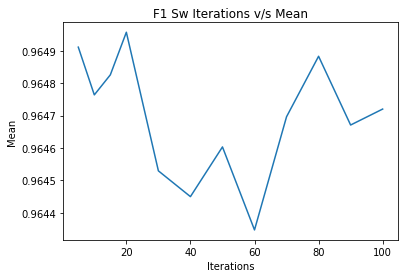

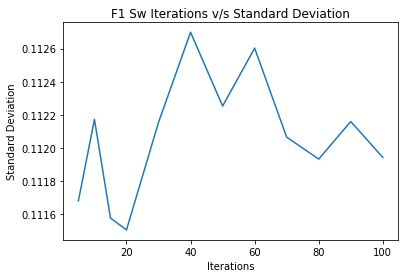

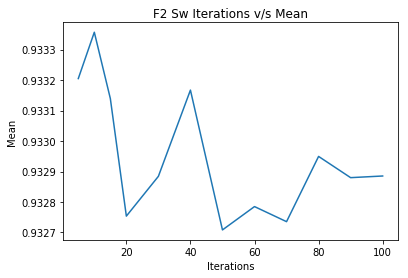

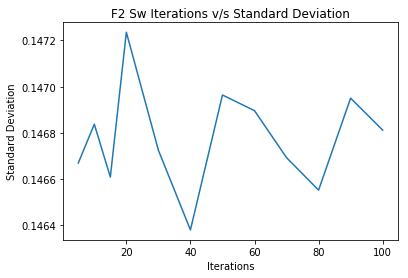

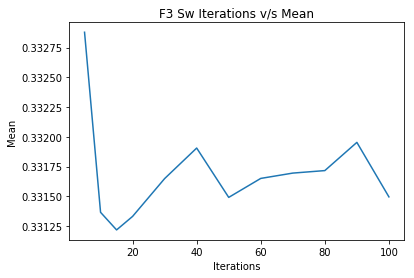

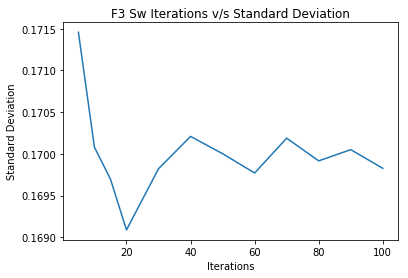

In [29]:
#Means and STDevs of Sw Data calculation:

SwF1mean,SwF1STDV = Mean_stdev(f1ArcSw1)     #print(F1STDV)
SwF2mean,SwF2STDV = Mean_stdev(f2ArcSw)
SwF3mean,SwF3STDV = Mean_stdev(f3ArcSw)

# plotting the Mean and Std dev


plt.plot(ITER, SwF1mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('F1 Sw Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, SwF1STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('F1 Sw Iterations v/s Standard Deviation')
plt.show()

plt.plot(ITER, SwF2mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('F2 Sw Iterations v/s Mean')  #plt.xscale("log")
f1ArcSw1 = Remv_nan(f1ArcSw)
plt.show()

plt.plot(ITER, SwF2STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('F2 Sw Iterations v/s Standard Deviation')
plt.show()

plt.plot(ITER, SwF3mean, label = "Mean")
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.title('F3 Sw Iterations v/s Mean')  #plt.xscale("log")
plt.show()

plt.plot(ITER, SwF3STDV, label = "Standard Deviation")
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.title('F3 Sw Iterations v/s Standard Deviation')
plt.show()



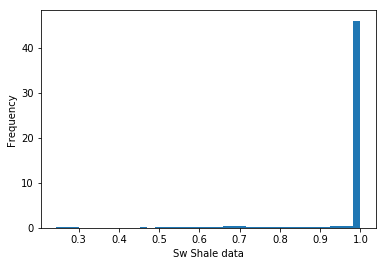

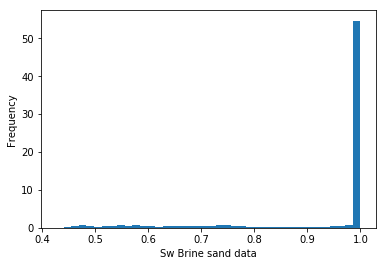

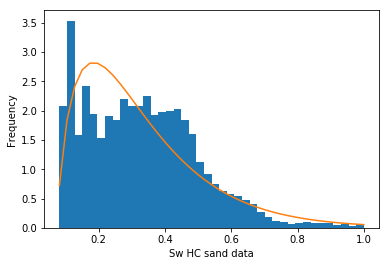

In [30]:
_, bins, _ = plt.hist(f1ArcSw1[-1],40, density=1)
plt.xlabel("Sw Shale data")
#plt.xscale("log")
plt.ylabel("Frequency")
plt.show()


_, bins, _ = plt.hist(f2ArcSw[-1],40, density=1)
plt.xlabel("Sw Brine sand data")
#plt.xscale("log")
plt.ylabel("Frequency")
plt.show()

_, bins, _ = plt.hist(f3ArcSw[-1],40, density=1)
m1,m2,q  = scipy.stats.pearson3.fit(f3ArcSw[-1])    
best_fit_line = scipy.stats.pearson3.pdf(bins, m1,m2,q)
plt.plot(bins, best_fit_line)                     
plt.xlabel("Sw HC sand data")
#plt.xscale("log")
plt.ylabel("Frequency")
plt.show()


In [31]:
#P10 P50 P90 for Sw:

def SATshbr_itp10p50p90ConfInt(G):
    L = copy.deepcopy(G)
    P10,P50,P90,p10,p50,p90 = [],[],[],[],[],[]
    ASD = float(1)               #print(ASD)

    c1,c2 =0,0
    for i in range(len(L)):
        if L[i]<=ASD:
            c1+=1
        elif L[i]>=ASD:
            c2+=1
                                                      #print(c1,c2)
    prop1,prop2 = c1/(c1+c2), c2/(c1+c2)
    c1+c2==len(L)

    p5  = np.percentile(L, (prop1*10))
    p95 = np.percentile(L, (100-(prop2*10)))
    p25 = np.percentile(L, (prop1*50))
    p75 = np.percentile(L, (100-(prop2*50)))
    p45 = np.percentile(L, prop1*90)
    p55 = np.percentile(L, (100-(prop2*90)))
    
    i=0
    while (i<len(L)):     
        if L[i]>= p45 and L[i] <= p55:      
            P10.append(L[i])
        else: 
            P10.append(np.NaN)
            
        if L[i]>= p25 and L[i] <= p75:
            P50.append(L[i])
        else: 
            P50.append(np.NaN)
        if L[i]>= p5 and L[i] <= p95:
            P90.append(L[i])
        else:
            P90.append(np.NaN)
        i+=1    
    return(P10,P50,P90)
    
def SATshbr_p10p50p90listConfInt(G,i):
    L = split_data(G,i)
    A10,A50,A90 = [],[],[]
    for i in range(len(L)):
        a ,b, c = SATshbr_itp10p50p90ConfInt(L[i])
        A10.extend(a)
        A50.extend(b)
        A90.extend(c)
    return(A10,A50,A90)


def SATshbr_Iter_P105090ConfInt(G):
    f10,f50,f90 = [],[],[]
    for i in range(len(ITER)):
        a ,b, c = SATshbr_p10p50p90listConfInt(G[i],ITER[i])
        f10.append(a)
        f50.append(b)
        f90.append(c)
    return(f10,f50,f90)    


def SATitp10p50p90ConfInt(G):
    L = copy.deepcopy(G)
    P10,P50,P90,p10,p50,p90 = [],[],[],[],[],[]
    
    params = stats.pearson3.fit(L)                 #print(params)
    def your_density(x):
        return -stats.pearson3.pdf(x,*params)
    ASD = minimize(your_density,0.5).x                #print(ASD)

    c1,c2 =0,0
    for i in range(len(L)):
        if L[i]<=ASD:
            c1+=1
        elif L[i]>=ASD:
            c2+=1
                                                      #print(c1,c2)
    prop1,prop2 = c1/(c1+c2), c2/(c1+c2)
    c1+c2==len(L)

    p5  = np.percentile(L, (prop1*10))
    p95 = np.percentile(L, (100-(prop2*10)))
    p25 = np.percentile(L, (prop1*50))
    p75 = np.percentile(L, (100-(prop2*50)))
    p45 = np.percentile(L, prop1*90)
    p55 = np.percentile(L, (100-(prop2*90)))
    
    i=0
    while (i<len(L)):     
        if L[i]>= p45 and L[i] <= p55:      
            P10.append(L[i])
        else: 
            P10.append(np.NaN)
            
        if L[i]>= p25 and L[i] <= p75:
            P50.append(L[i])
        else: 
            P50.append(np.NaN)
        if L[i]>= p5 and L[i] <= p95:
            P90.append(L[i])
        else:
            P90.append(np.NaN)
        i+=1    
    return(P10,P50,P90)
    
def SATp10p50p90listConfInt(G,i):
    L = split_data(G,i)
    A10,A50,A90 = [],[],[]
    for i in range(len(L)):
        a ,b, c = SATitp10p50p90ConfInt(L[i])
        A10.extend(a)
        A50.extend(b)
        A90.extend(c)
    return(A10,A50,A90)


def SATIter_P105090ConfInt(G):
    f10,f50,f90 = [],[],[]
    for i in range(len(ITER)):
        a ,b, c = SATp10p50p90listConfInt(G[i],ITER[i])
        f10.append(a)
        f50.append(b)
        f90.append(c)
    return(f10,f50,f90)    

f1ArcSwp10C, f1ArcSwp50C, f1ArcSwp90C = SATshbr_Iter_P105090ConfInt(f1ArcSw)
f2ArcSwp10C, f2ArcSwp50C, f2ArcSwp90C = SATshbr_Iter_P105090ConfInt(f2ArcSw)
f3ArcSwp10C, f3ArcSwp50C, f3ArcSwp90C = SATIter_P105090ConfInt(f3ArcSw)

f1ArcSwp10, f1ArcSwp50, f1ArcSwp90 = Iter_P105090(f1ArcSw)  #print(GLDp50)
f2ArcSwp10, f2ArcSwp50, f2ArcSwp90 = Iter_P105090(f2ArcSw)
f3ArcSwp10, f3ArcSwp50, f3ArcSwp90 = Iter_P105090(f3ArcSw) 

len(f1Dp10[0])==len(f1ArcSwp10[0])

C:\Python\pl_pydistribution_3.4.4.5Qt5\python-3.4.4.amd64\lib\site-packages\numpy\lib\function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


True

In [32]:
#Preparing Sw data to send data to PL:

f1ARCSW  = [f1ArcSw,f1ArcSwp10, f1ArcSwp50, f1ArcSwp90]
f2ARCSW  = [f2ArcSw,f2ArcSwp10, f2ArcSwp50, f2ArcSwp90]
f3ARCSW  = [f3ArcSw,f3ArcSwp10, f3ArcSwp50, f3ArcSwp90]

f1ARCSWC = [f1ArcSw,f1ArcSwp10C, f1ArcSwp50C, f1ArcSwp90C]
f2ARCSWC = [f2ArcSw,f2ArcSwp10C, f2ArcSwp50C, f2ArcSwp90C]
f3ARCSWC = [f3ArcSw,f3ArcSwp10C, f3ArcSwp50C, f3ArcSwp90C]

F1ArcSw, F1ArcSwp10, F1ArcSwp50, F1ArcSwp90    = faciespordata(f1ARCSW,0) 
F2ArcSw, F2ArcSwp10, F2ArcSwp50, F2ArcSwp90    = faciespordata(f2ARCSW,1) 
F3ArcSw, F3ArcSwp10, F3ArcSwp50, F3ArcSwp90    = faciespordata(f3ARCSW,2) 

F1ArcSw, F1ArcSwp10C, F1ArcSwp50C, F1ArcSwp90C = faciespordata(f1ARCSWC,0) 
F2ArcSw, F2ArcSwp10C, F2ArcSwp50C, F2ArcSwp90C = faciespordata(f2ARCSWC,1) 
F3ArcSw, F3ArcSwp10C, F3ArcSwp50C, F3ArcSwp90C = faciespordata(f3ARCSWC,2) 


In [169]:
print(ITER)
ind = -1
itx = ITER[ind]

[5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [170]:
# Dummy depth

def createListDummy_depth(r1, r2):
    return (list(np.arange(r1, ((r2-2)/2)+1, 0.5)))

dl = len(F1DP[ind])
ddepth = createListDummy_depth(0,dl)

In [171]:
#Porosity Data:

f1Pordf= pd.DataFrame({'DEPTH': ddepth, 'f1DPvclq' + str(itx): pd.Series(F1DP[ind]), 'f1DPvclq' + str(itx)+'p10': pd.Series(F1Dp10[ind]),'f1DPvclq' + str(itx)+'p50': pd.Series(F1Dp50[ind]),'f1DPvclq' + str(itx)+'p90': pd.Series(F1Dp90[ind]) }) #print(PordfGLD)

f2Pordf = pd.DataFrame({'f2DPvclq' + str(itx): pd.Series(F2DP[ind]), 'f2DPvclq' + str(itx)+'p10': pd.Series(F2Dp10[ind]),'f2DPvclq' + str(itx)+'p50': pd.Series(F2Dp50[ind]),'f2DPvclq' + str(itx)+'p90': pd.Series(F2Dp90[ind]) })

f3Pordf= pd.DataFrame({ 'f3DPvclq' + str(itx): pd.Series(F3DP[ind]), 'f3DPvclq' + str(itx)+'p10': pd.Series(F3Dp10[ind]),'f3DPvclq' + str(itx)+'p50': pd.Series(F3Dp50[ind]),'f3DPvclq' + str(itx)+'p90': pd.Series(F3Dp90[ind]) })

POR = pd.DataFrame({  'AllFDPvclq' + str(itx): pd.Series( FDP[ind])})
#print(POR)



#Sending Data to PL

#Adding this Porosity data to Powerlog

GDPMC = pd.concat([f1Pordf,f2Pordf,f3Pordf,POR], axis=1)  
#GDPMC.to_csv('file1.csv')
#print(GDPMC)
plf.set_curves_for_uwi(uwi_list[0], GDPMC)


In [172]:
#Porosity CI:
f1PordfC= pd.DataFrame({'DEPTH': ddepth,'f1DPvclq' + str(itx)+'p10C': pd.Series(F1Dp10C[ind]),'f1DPvclq' + str(itx)+'p50C': pd.Series(F1Dp50C[ind]),'f1DPvclq' + str(itx)+'p90C': pd.Series(F1Dp90C[ind]) }) #print(PordfGLD)

f2PordfC = pd.DataFrame({'f2DPvclq' + str(itx)+'p10C': pd.Series(F2Dp10C[ind]),'f2DPvclq' + str(itx)+'p50C': pd.Series(F2Dp50C[ind]),'f2DPvclq' + str(itx)+'p90C': pd.Series(F2Dp90C[ind]) })

f3PordfC= pd.DataFrame({ 'f3DPvclq' + str(itx)+'p10C': pd.Series(F3Dp10C[ind]),'f3DPvclq' + str(itx)+'p50C': pd.Series(F3Dp50C[ind]),'f3DPvclq' + str(itx)+'p90C': pd.Series(F3Dp90C[ind]) })

#print(POR)

#Sending Data to PL

#Adding this Porosity data to PowerlogDP

GDPMCC = pd.concat([f1PordfC,f2PordfC,f3PordfC], axis=1)  
#GDPMC.to_csv('file1.csv')
#print(GDPMC)
plf.set_curves_for_uwi(uwi_list[0], GDPMCC)


In [173]:
# For VCL:
f1Vcdf= pd.DataFrame({'DEPTH': ddepth, 'f1vclq'+str(itx): pd.Series(F1Vc[ind]), 'f1vclq'+str(itx)+'p10': pd.Series(F1Vcp10[ind]),'f1vclq'+str(itx)+'p50': pd.Series(F1Vcp50[ind]),'f1vclq'+str(itx)+'p90': pd.Series(F1Vcp90[ind]) }) #print(PordfGLD)

f2Vcdf = pd.DataFrame({'f2vclq'+str(itx): pd.Series(F2Vc[ind]), 'f2vclq'+str(itx)+'p10': pd.Series(F2Vcp10[ind]),'f2vclq'+str(itx)+'p50': pd.Series(F2Vcp50[ind]),'f2vclq'+str(itx)+'p90': pd.Series(F2Vcp90[ind]) })

f3Vcdf= pd.DataFrame({ 'f3vclq'+str(itx): pd.Series(F3Vc[ind]), 'f3vclq'+str(itx)+'p10': pd.Series(F3Vcp10[ind]),'f3vclq'+str(itx)+'p50': pd.Series(F3Vcp50[ind]),'f3vclq'+str(itx)+'p90': pd.Series(F3Vcp90[ind]) })

FVCLdf = pd.DataFrame({  'AllFvclq'+str(itx): pd.Series( VC[ind])})
#print(POR)



#Sending Data to PL

#Adding this Porosity data to Powerlog

GDPMCvc = pd.concat([f1Vcdf,f2Vcdf,f3Vcdf,FVCLdf], axis=1)  
#GDPMC.to_csv('file1.csv')
#print(GDPMC)
plf.set_curves_for_uwi(uwi_list[0], GDPMCvc)


In [174]:
# For VCL CI:
f1VcCdf= pd.DataFrame({'DEPTH': ddepth, 'f1vclq'+str(itx)+'p10C': pd.Series(F1Vcp10C[ind]),'f1vclq'+str(itx)+'p50C': pd.Series(F1Vcp50C[ind]),'f1vclq'+str(itx)+'p90C': pd.Series(F1Vcp90C[ind]) }) #print(PordfGLD)

f2VcCdf = pd.DataFrame({'f2vclq'+str(itx)+'p10C': pd.Series(F2Vcp10C[ind]),'f2vclq'+str(itx)+'p50C': pd.Series(F2Vcp50C[ind]),'f2vclq'+str(itx)+'p90C': pd.Series(F2Vcp90C[ind]) })

f3VcCdf= pd.DataFrame({ 'f3vclq'+str(itx)+'p10C': pd.Series(F3Vcp10C[ind]),'f3vclq'+str(itx)+'p50C': pd.Series(F3Vcp50C[ind]),'f3vclq'+str(itx)+'p90C': pd.Series(F3Vcp90C[ind]) })

#print(POR)



#Sending Data to PL

#Adding this Porosity data to Powerlog

GDPMCVC = pd.concat([f1VcCdf,f2VcCdf,f3VcCdf], axis=1)  
#GDPMC.to_csv('file1.csv')
#print(GDPMC)
plf.set_curves_for_uwi(uwi_list[0], GDPMCVC)

In [175]:
# Water Saturation:
GRMC4 = pd.DataFrame({'DEPTH': ddepth,       'f1ArcSwvclq'+str(itx): pd.Series(F1ArcSw[ind]),          'f2ArcSwvclq'+str(itx): pd.Series(F2ArcSw[ind]),         'f3ArcSwvclq'+str(itx): pd.Series(F3ArcSw[ind]),'AllFArcSwvclq'+str(itx) : pd.Series(FDPArcSw[ind]) })  
GRMC5 = pd.DataFrame({'DEPTH': ddepth, 'f1ArcSwvclq'+str(itx)+'p10': pd.Series(F1ArcSwp10[ind]), 'f1ArcSwvclq'+str(itx)+'p50': pd.Series(F1ArcSwp50[ind]),'f1ArcSwvclq'+str(itx)+'p90': pd.Series(F1ArcSwp90[ind]) })
GRMC6 = pd.DataFrame({'DEPTH': ddepth, 'f2ArcSwvclq'+str(itx)+'p10': pd.Series(F2ArcSwp10[ind]), 'f2ArcSwvclq'+str(itx)+'p50': pd.Series(F2ArcSwp50[ind]),'f2ArcSwvclq'+str(itx)+'p90': pd.Series(F2ArcSwp90[ind]) })
GRMC7 = pd.DataFrame({'DEPTH': ddepth, 'f3ArcSwvclq'+str(itx)+'p10': pd.Series(F3ArcSwp10[ind]), 'f3ArcSwvclq'+str(itx)+'p50': pd.Series(F3ArcSwp50[ind]),'f3ArcSwvclq'+str(itx)+'p90': pd.Series(F3ArcSwp90[ind]) })

plf.set_curves_for_uwi(uwi_list[0], GRMC4)


In [176]:
plf.set_curves_for_uwi(uwi_list[0], GRMC5)


In [177]:
plf.set_curves_for_uwi(uwi_list[0], GRMC6)


In [178]:
plf.set_curves_for_uwi(uwi_list[0], GRMC7)


In [179]:
# Water Saturation CI:

GRMC8  = pd.DataFrame({'DEPTH': ddepth, 'f1ArcSwvclq'+str(itx)+'p10C': pd.Series(F1ArcSwp10C[ind]), 'f1ArcSwvclq'+str(itx)+'p50C': pd.Series(F1ArcSwp50C[ind]),'f1ArcSwvclq'+str(itx)+'p90C': pd.Series(F1ArcSwp90C[ind]) })  
GRMC9  = pd.DataFrame({'DEPTH': ddepth, 'f2ArcSwvclq'+str(itx)+'p10C': pd.Series(F2ArcSwp10C[ind]), 'f2ArcSwvclq'+str(itx)+'p50C': pd.Series(F2ArcSwp50C[ind]),'f2ArcSwvclq'+str(itx)+'p90C': pd.Series(F2ArcSwp90C[ind]) }) 
GRMC10 = pd.DataFrame({'DEPTH': ddepth, 'f3ArcSwvclq'+str(itx)+'p10C': pd.Series(F3ArcSwp10C[ind]), 'f3ArcSwvclq'+str(itx)+'p50C': pd.Series(F3ArcSwp50C[ind]),'f3ArcSwvclq'+str(itx)+'p90C': pd.Series(F3ArcSwp90C[ind]) }) 


In [180]:
plf.set_curves_for_uwi(uwi_list[0], GRMC8)


In [181]:
plf.set_curves_for_uwi(uwi_list[0], GRMC9)

In [182]:
plf.set_curves_for_uwi(uwi_list[0], GRMC10)